## LSTM-Based Extreme Weather Forcasting

### Introduction

The following is a beginner's work and thoughts.

The idea of using LSTM and convolution for frame prediction came to me intuitively, and indeed it is already being explored:
1. It is so popular that convolution & lstm are combined into what is known as ConvLSTM layer. **[1]**
2. There are papers (mostly) in the last 3 years involving ConvLSTM predictions, just like the video predictions demonstrated in **[1]**, but improved. It's a surprisingly new field! (see **[2]**, **[3]**)
3. The idea of using Navier-Stokes and training limited set of parameters is well explored, but seemes that lately it's popular to guess the entire model to catch subtleties, or find parameter space that is less chaotic.**[4]**
4. The ideas of using language models are also already explored, though I didn't look too much into that.

### Summary of Findings
What I've discovered is that - one can keep a model similar to the classic frame prediction of **[1]** with little tweaks (and maybe 1 more layer). To ease the learning (especially if you don't have dedicated hardware) I've made it more similar to the video prediction of characters where the image is binary image (shapes can be outlined). The model seems to be able to deal with the deformations even within few minutes of training.

It was surprising to find that through *incomplete* training the weakness of the model which averages adjacent frames "recovers" in a sense some of the relative intensity, supposedly through this context of movement and continuity. (Happy coincidence with the statistics of percipitation?).

The results are far from perfect but might be usable for finding extreme perticipation areas and perform much better than expected, given the primitive model and a rather tiny dataset. Here, it's the climate.gov monthly percipitation image dataset. **[5]**


### References
  [1] Keras, ConvLSTM - Keras manual, available from [here](https://keras.io/examples/vision/conv_lstm/)

  [2] Lou, Li, Ye, IEEE, selected topics in applied earth observations & remote sensing, vol. 14, 2021, available from [here](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=9272611)

  [3] Frederik Kratzert, Johannes Kepler University , CUAHSI presentation, LSTM networks for rainfall-runoff modeling, 2019, Youtube video available [here](https://www.youtube.com/watch?v=skFAT8i2bZI)

  [4] Tapio Schnider & CLIMA (Caltech), AI for Good presentation, AI-accelerated climate modeling, Youtube video available from [here](https://www.youtube.com/watch?v=6HWWcsm5V00)

  [5] Climate.gov, Total Monthly percipitation, available from [here](https://www.climate.gov/maps-data/data-snapshots/data-source/precipitation-monthly-total)


## acquire datasets

In [ ]:
!rm -rf images
!mkdir images
!cd images; wget -q -r -np https://www.climate.gov/data/Precipitation--Monthly--Total--CONUS/01-small/

####################################################################

#### original dataset for keras demo

# # Download and load the dataset.
# fpath = keras.utils.get_file(
#     "moving_mnist.npy",
#     "http://www.cs.toronto.edu/~nitish/unsupervised_video/mnist_test_seq.npy",
# )
# dataset = np.load(fpath)
# # Swap the axes representing the number of frames and number of data samples.
# dataset = np.swapaxes(dataset, 0, 1)
# # We'll pick out 1000 of the 10000 total examples and use those.
# dataset = dataset[:1000, ...]
# # Add a channel dimension since the images are grayscale.
# dataset = np.expand_dims(dataset, axis=-1)

In [ ]:
ch_red, ch_green, ch_blue = range(3)
channel = ch_blue

## setup

In [ ]:
# !pip install tensorflow_addons
# import tensorflow_addons as tfa
# !pip install imageio

import glob
import PIL

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import io
import imageio
from IPython.display import Image, display
from ipywidgets import widgets, Layout, HBox

## dataset

In [ ]:
NUM_BATCHES = 27
INTENSITY_THRESHOLD = 0.75

def open_img(path):
  img = PIL.Image.open(path)
  w, h = img.size
  img = img.crop((0, 0, w, h-70)).resize((64,64), PIL.Image.ANTIALIAS) 
  return np.array(img) 

dataset_files = sorted(glob.glob('images/**/**/**/**/*.png'))
dataset = []
dataset_original = []
t = 0

print(len(dataset_files))
img_tmpl = 0

for fpath in dataset_files:
  img = open_img(fpath)
  img_np = np.array(img)[:,:,channel,]
  dataset_original += [img_np]
  # take relevant channel only and make binary
  dataset += [img_np < np.mean(img_np)*INTENSITY_THRESHOLD] 
  if t == 0:
    img_tmpl = img
  t += 1

dataset = np.array(np.array_split(dataset, NUM_BATCHES))
# Add a channel dimension since the images are grayscale.
dataset = np.expand_dims(dataset, axis=-1)

dataset_original = np.array(np.array_split(dataset_original, NUM_BATCHES))
# Add a channel dimension since the images are grayscale.
dataset_original = np.expand_dims(dataset_original, axis=-1)


######################

# Split into train and validation sets using indexing to optimize memory.
indexes = np.arange(dataset.shape[0])
np.random.shuffle(indexes)
train_index = indexes[: int(0.9 * dataset.shape[0])]
val_index = indexes[int(0.9 * dataset.shape[0]) :]
train_dataset = dataset[train_index]
val_dataset = dataset[val_index]


val_original = dataset_original[val_index]

# # Normalize the data to the 0-1 range.
# train_dataset = train_dataset / 255
# val_dataset = val_dataset / 255

# We'll define a helper function to shift the frames, where
# `x` is frames 0 to n - 1, and `y` is frames 1 to n.
def create_shifted_frames(data):
    x = data[:, 0 : data.shape[1] - 1, :, :]
    y = data[:, 1 : data.shape[1], :, :]
    return x, y


# Apply the processing function to the datasets.
x_train, y_train = create_shifted_frames(train_dataset)
x_val, y_val = create_shifted_frames(val_dataset)

# Inspect the dataset.
print("Training Dataset Shapes: " + str(x_train.shape) + ", " + str(y_train.shape))
print("Validation Dataset Shapes: " + str(x_val.shape) + ", " + str(y_val.shape))

## visualize

In [ ]:
# Construct a figure on which we will visualize the images.
fig, axes = plt.subplots(2, 3, figsize=(10, 8))

# Plot each of the sequential images for one random data example.
data_choice = np.random.choice(range(len(train_dataset)), size=1)[0]
for idx, ax in enumerate(axes.flat):
    ax.imshow(np.squeeze(train_dataset[data_choice][idx]), cmap='gray')
    ax.set_title(f"Frame {idx + 1}")
    ax.axis("off")

# Print information and display the figure.
print(f"Displaying frames for example {data_choice}.")
plt.show()

## model

In [17]:
model = keras.Sequential([
  keras.layers.Input(shape=(None, *x_train.shape[2:])),
  keras.layers.ConvLSTM2D(
    filters=64,
    kernel_size=(3, 3),
    padding="same",
    return_sequences=True,
    activation="relu",
  ),
  keras.layers.BatchNormalization(),
  keras.layers.ConvLSTM2D(
                    filters=32,
                    kernel_size=(3, 3),
                    padding="same",
                    return_sequences=True,
                    activation="relu",
                    ),
  keras.layers.BatchNormalization(),
  layers.ConvLSTM2D(
    filters=32,
    kernel_size=(1, 1),
    padding="same",
    return_sequences=True,
    activation="relu",
  ),
  layers.Conv3D(
      filters=1, kernel_size=(3, 3, 3), activation="sigmoid", padding="same"
  )
])

# Loss functtion
# playing with the loss
# def imgloss(y_true, y_pred):
#   ssim = tf.reduce_mean(tf.image.ssim(y_true, y_pred, 1.0))
#   mse = keras.losses.mse(y_true, y_pred)
#   bce = keras.losses.binary_crossentropy(y_true, y_pred)
#   avg_mass_cons = tf.abs(tf.reduce_sum(y_pred) - tf.reduce_sum(y_true))

#   return 0.3*ssim + 0.2*bce + 0.3 * mse +0.2*avg_mass_cons

model.compile(
    # loss=imgloss,
    # optimizer=keras.optimizers.SGD(),
    loss = keras.losses.binary_crossentropy,
    optimizer=keras.optimizers.Adam(),
    metrics=['accuracy']
)


## training

Epoch 1/30
24/24 [==============================] - 55s 2s/step - loss: 0.2227 - accuracy: 0.9401 - val_loss: 0.5064 - val_accuracy: 0.9794 - lr: 0.0010
Epoch 2/30
24/24 [==============================] - 49s 2s/step - loss: 0.0766 - accuracy: 0.9772 - val_loss: 0.3982 - val_accuracy: 0.9794 - lr: 0.0010
Epoch 3/30
24/24 [==============================] - 49s 2s/step - loss: 0.0344 - accuracy: 0.9891 - val_loss: 0.3471 - val_accuracy: 0.9794 - lr: 0.0010
Epoch 4/30
24/24 [==============================] - 49s 2s/step - loss: 0.0196 - accuracy: 0.9942 - val_loss: 0.3047 - val_accuracy: 0.9794 - lr: 0.0010
Epoch 5/30
24/24 [==============================] - 49s 2s/step - loss: 0.0157 - accuracy: 0.9956 - val_loss: 0.2573 - val_accuracy: 0.9794 - lr: 0.0010
Epoch 6/30
24/24 [==============================] - 49s 2s/step - loss: 0.0135 - accuracy: 0.9965 - val_loss: 0.2142 - val_accuracy: 0.9794 - lr: 0.0010
Epoch 7/30
24/24 [==============================] - 49s 2s/step - loss: 0.0119 - a

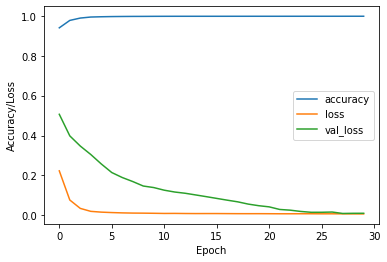

In [18]:
# Define some callbacks to improve training.
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)

# Define modifiable training hyperparameters.
epochs = 30
batch_size = 1

# Fit the model to the training data.
history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping, reduce_lr]
)

for tag in ['accuracy', 'loss', 'val_loss']:
  plt.plot(history.history[tag], label=tag)
plt.xlabel('Epoch')
plt.ylabel('Accuracy/Loss')
plt.legend()

## Resulted Gifs

In [30]:
num_frames = 5

# Select a few random examples from the dataset.
indx = np.random.choice(range(len(val_dataset)), size=5)
examples = val_dataset[indx]
examples_original = val_original[indx]

# Iterate over the examples and predict the frames.
predicted_videos = []
t=0
for example in examples:
    # Pick the first/last ten frames from the example.
    frames = example[:num_frames, ...]
    original_frames = examples_original[t][num_frames:, ...]
    t+=1
    new_predictions = np.zeros(shape=(num_frames, *frames[0].shape))

    # Predict a new set of 10 frames.
    for i in range(num_frames):
        # Extract the model's prediction and post-process it.
        frames = example[: num_frames + i + 1, ...]
        new_prediction = model.predict(np.expand_dims(frames, axis=0))
        new_prediction = np.squeeze(new_prediction, axis=0)
        predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)
        
        # Extend the set of prediction frames.
        new_predictions[i] = predicted_frame

    # Create and save GIFs for each of the ground truth/prediction images.
    for frame_set in [original_frames, new_predictions]:
        # Construct a GIF from the selected video frames.
        current_frames = np.squeeze(frame_set)
        current_frames = current_frames[:,:,] * np.ones(1)
        current_frames = (current_frames * 255).astype(np.uint8)
        current_frames = list(current_frames)

        # Construct a GIF from the frames.
        with io.BytesIO() as gif:
            imageio.mimsave(gif, current_frames, "GIF", fps=5)
            predicted_videos.append(gif.getvalue())

# Display the videos.
print(" Truth\tPrediction")
for i in range(0, len(predicted_videos), 2):
    # Construct and display an `HBox` with the ground truth and prediction.

    size = 128

    box = HBox(
        [
          widgets.Image(value=predicted_videos[i], width=size, height=size),
          widgets.Image(value=predicted_videos[i + 1], width=size, height=size)
        ]
    )
    display(box)

 Truth	Prediction
